<a href="https://colab.research.google.com/github/b-remy/score-estimation-comparison/blob/master/notebooks/Denoiser_haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# if run on colab
!pip install --quiet git+https://github.com/deepmind/dm-haiku
# need to install nsec...

In [2]:
%pylab inline 
%load_ext autoreload
%autoreload 2

import numpy as onp
import jax
import jax.numpy as jnp
from jax.experimental import optix
import haiku as hk
import tensorflow_probability as tfpp; tfp = tfpp.experimental.substrates.jax
from functools import partial

from nsec.models.dae.dae import DAE
from nsec.utils import display_score_two_moons
from nsec.datasets.two_moons import get_two_moons

tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [3]:
two_moons = get_two_moons(0.05)

# This code is taken from make_moons in sklearn
resolution = 1024
outer_circ_x = jnp.cos(jnp.linspace(0, jnp.pi, resolution))
outer_circ_y = jnp.sin(jnp.linspace(0, jnp.pi, resolution))
inner_circ_x = 1 - jnp.cos(jnp.linspace(0, jnp.pi, resolution))
inner_circ_y = 1 - jnp.sin(jnp.linspace(0, jnp.pi, resolution)) - .5

X = jnp.append(outer_circ_x, inner_circ_x)
Y = jnp.append(outer_circ_y, inner_circ_y)
coords = jnp.vstack([X,Y])

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


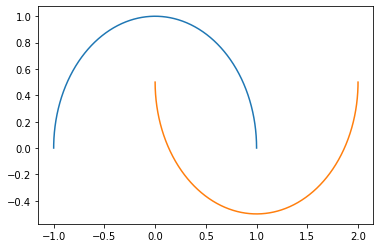

In [4]:
plot(outer_circ_x,outer_circ_y)
plot(inner_circ_x,inner_circ_y)

In [5]:
sigma=0.02

# We approximate the 2 moons with a large mixture
distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=np.ones(2*resolution)/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=coords.T, scale_identity_multiplier=sigma) 
)

coords.T.shape

(2048, 2)

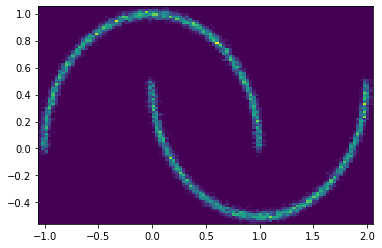

In [6]:
rng_key = jax.random.PRNGKey(seed=0)
samps = distribution.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [7]:
# But now we can also compute the gradients of log p :-)
score = jax.vmap(jax.grad(distribution.log_prob))

In [8]:
score(np.array([0.,0.]).reshape([1,2]))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


DeviceArray([[264.33215, 132.166  ]], dtype=float32)

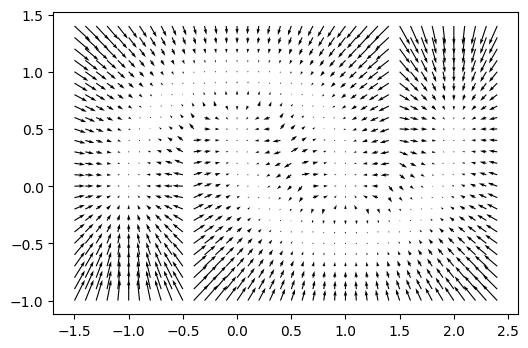

In [9]:
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

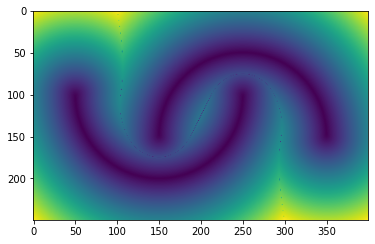

In [10]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1., 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = score(points).reshape([len(Y), len(X),2])

imshow(sqrt(g[:,:,0]**2 + g[:,:,1]**2))

**Implement a denoiser**

```
class DAE(hk.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
    
    def __call__(self, x, is_training=False):
        # Encoder
        net = hk.Linear(128)(x)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        # Decoder
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)
        
        return net
```

In [1]:
def forward(x, is_training=False):
    denoiser = DAE()
    return denoiser(x, is_training)
             
model = hk.transform_with_state(forward)

NameError: name 'hk' is not defined

In [12]:
batch_size = 512
step_size = 0.05

def get_batch(rng_key):
    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=np.ones(2*resolution)/resolution/2),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=coords.T, scale_identity_multiplier=sigma)
    )
    
    y = distribution.sample(batch_size, seed=rng_key)
    x = y + step_size * onp.random.randn(batch_size, 2)
    
    # x is a noisy sample, y is a sample from the distribution
    return {'x':x, 'y':y}

In [13]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [14]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model.apply(params, state, rng_key, batch['x'], is_training=True)
    ypred = batch['x'] + res
    loss = jnp.mean((ypred - batch['y'])**2)
    return loss, state

In [15]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [16]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 2)), is_training=True)
opt_state = optimizer.init(params)

In [17]:
losses = []
for step in range(5000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.072814
100 0.0024564466
200 0.0022875401
300 0.0023013954
400 0.001999116
500 0.002191688
600 0.001967289
700 0.002162272
800 0.001872363
900 0.0024037762
1000 0.0021402028
1100 0.0020128766
1200 0.0018188998
1300 0.001865328
1400 0.0017756029
1500 0.0019484363
1600 0.0018753621
1700 0.0016946997
1800 0.0019099488
1900 0.0021415537
2000 0.001751293
2100 0.0018125355
2200 0.0016246464
2300 0.0019246107
2400 0.001681032
2500 0.0016478528
2600 0.0017767439
2700 0.0015714598
2800 0.0015312076
2900 0.0018402392
3000 0.00189739
3100 0.0018360175
3200 0.0018711769
3300 0.0019227806
3400 0.0015705299
3500 0.0016878631
3600 0.0018363495
3700 0.0016271721
3800 0.001756006
3900 0.001735379
4000 0.0018142427
4100 0.0017161712
4200 0.0018553089
4300 0.0018175091
4400 0.0018526057
4500 0.0016073652
4600 0.0016992826
4700 0.001782727
4800 0.0014816555
4900 0.0016374482


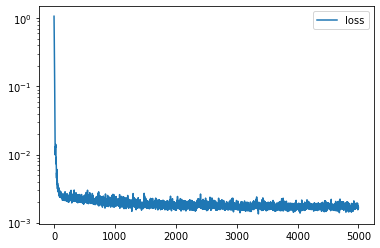

In [18]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [19]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

score = partial(model.apply, params, state, next(rng_seq))

In [20]:
res, state = score(points, is_training=False)

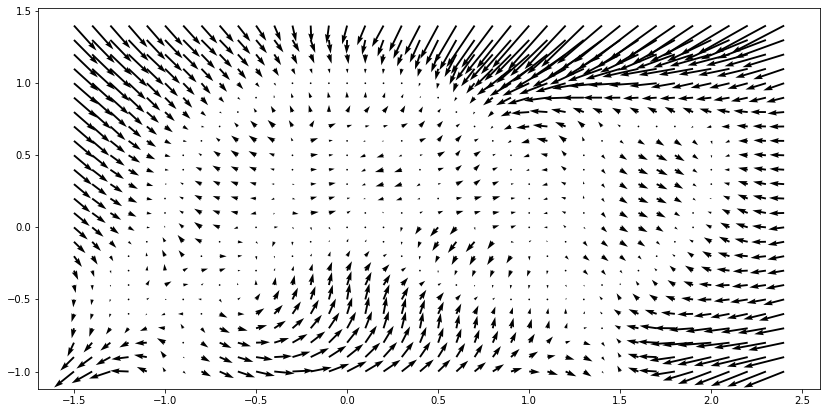

In [21]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


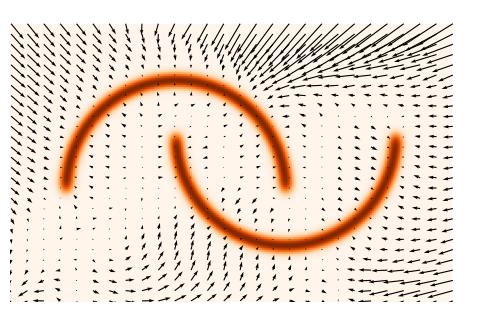

In [22]:
display_score_two_moons(score, two_moons, is_amortized=False, is_reg=True)

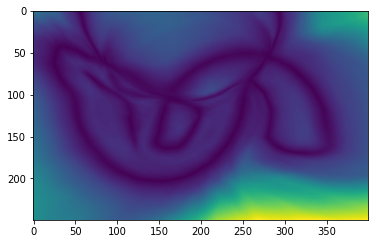

In [23]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score(points, is_training=False)
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))